In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)

In [3]:
import os
from micdrop.utils.git_utils import get_git_root
from micdrop.src.preprocessing.run_preprocessing import load_raw_data, run_preprocessing

In [4]:
git_root = get_git_root(os.getcwd())

In [5]:
# Approx 50% urban, non-urban split (is non-urban suburban or rural? feels mostly suburban here when checking distributions of a few of the larger cities)
# Some cities appear entirely urban (st louis, philadelphia, st petersburg, west park, nashville) -> how much do we trust the urban / non-urban split?
# Approx 2% with credit card on file
# Approx 30% students (younger)
# Favorite genre heavily skewed to hip_hop -> was this a campaign targeting hiphop listeners?
# Nationwide (US only) with a few states more heavily represented (by population?) -> seems to be miami area, los angeles area, hawaii, and scattered other big cities. 
# Somewhat messy. Would be nice to have a zipcode (for urban / non-urban) or metro area field (lax vs los angeles, miami vs miami beach, atl vs atlanta)
# Big long tail of other cities
# 70% towards mobile, 30% towards desktop
# Click to subscribe rate is 7%, which is pretty good.


# Interesting that the data uses the holiday period (christmas + new years). May not be 100% representative of the rest of the year.
# Ex: people are more likely to NOT be at their home address at this time. So ad effectiveness likely also needs an approx location of device
# and then create an "is_near_home" feature

# Other demographics probably important: age, income

In [6]:
df = run_preprocessing(git_root)

Reading data from: C:/Users/Furton Akos/Desktop/stackoverflow_auto_mod/data/raw/micdrop_subsciptions_data_v1.csv


In [7]:
def calc_click_to_subscribe_ratio(df, group_col, plot=False):
    df_grp = df.groupby(group_col)['subscriber'].mean()
    if plot:
        df_grp.plot.bar()
        
    return df_grp

student
non_student    0.073233
student        0.069303
Name: subscriber, dtype: float64

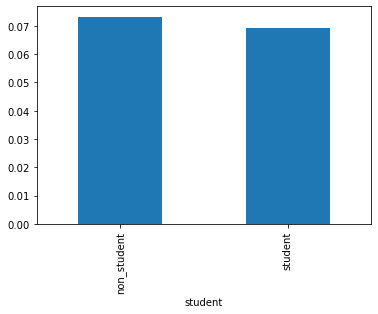

In [8]:
# Student status overall does not affect conversion rates
calc_click_to_subscribe_ratio(df, 'student', plot=True)

fav_genre
classical     0.052478
country       0.046154
hip_hop       0.072501
indie_rock    0.036107
latin         0.037699
punk_rock     0.054180
r&b           0.058518
techno        0.069606
unknown       0.086216
Name: subscriber, dtype: float64

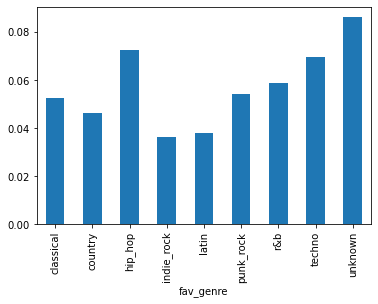

In [9]:
calc_click_to_subscribe_ratio(df, 'fav_genre', plot=True)

# For people who are correctly targeted (hip hop ads when hip hop is favorite genre) -> conversion is pretty good
# Build targeted ads based on people's preferred genres

credit_card_on_file
no     0.07078
yes    0.12973
Name: subscriber, dtype: float64

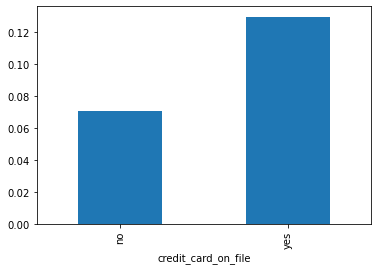

In [10]:
calc_click_to_subscribe_ratio(df, 'credit_card_on_file', plot=True)

# Conversion rate is significantly above average if credit card info already stored (existing customer, easy payment method)

day_of_week
Friday       0.073047
Monday       0.066225
Saturday     0.072650
Sunday       0.072286
Thursday     0.073526
Tuesday      0.072507
Wednesday    0.072671
Name: subscriber, dtype: float64

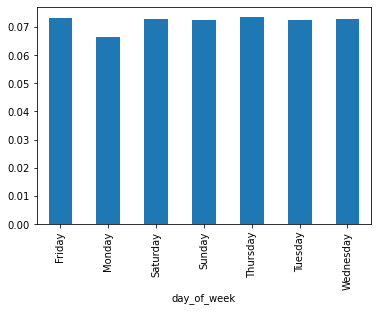

In [11]:
df["day_of_week"] = df["click_date"].dt.day_name()
calc_click_to_subscribe_ratio(df, 'day_of_week', plot=True)

# Conversion rate does not depend significantly on day of week, though Monday is somewhat lower. 

is_holiday
holiday        0.063948
not_holiday    0.072410
Name: subscriber, dtype: float64

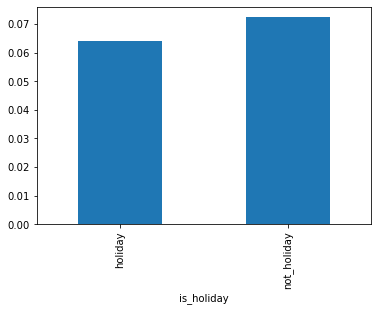

In [12]:
# Conversion rate is below average on holidays (Christmas, New Years). User behavior different on average day vs holiday
calc_click_to_subscribe_ratio(df, 'is_holiday', plot=True)

In [13]:
from micdrop.utils.constants import CITY_MAP, FILLNA_DICT, Y_VAR, NUMERIC_COLS, CATEGORICAL_COLS

data_dummy = pd.get_dummies(
        df[[Y_VAR] + CATEGORICAL_COLS + NUMERIC_COLS], dummy_na=True
    )

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
np.random.seed(12345)

#split into train and test to avoid overfitting
train, test = train_test_split(data_dummy, test_size = 0.33)

# build model
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(train.drop(Y_VAR, axis=1), train[Y_VAR])

RandomForestClassifier()

In [15]:
# Would probably perfer negative log loss. 
# TODO: Implement

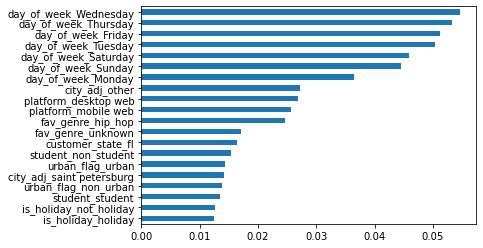

In [16]:
# Feature Importances
feat_importances = pd.Series(clf.feature_importances_, index=train.drop(Y_VAR, axis=1).columns)
feat_importances.sort_values()[-20:].plot(kind='barh')

In [17]:
# Web appears to be the most important
# followed by urban, lack of holiday, credit card on file, a few "other cities"

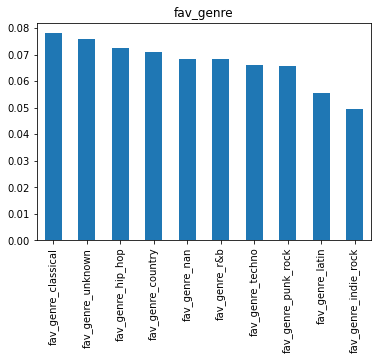

In [18]:
# Partial dependence plots
from pdpbox import pdp, info_plots

#country
pdp_iso = pdp.pdp_isolate(model=clf, 
                          dataset=train.drop(Y_VAR, axis=1),      
                          model_features=list(train.drop(Y_VAR, axis=1)), 
                          feature=[x for x in train.columns if "fav_genre" in x], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='fav_genre')

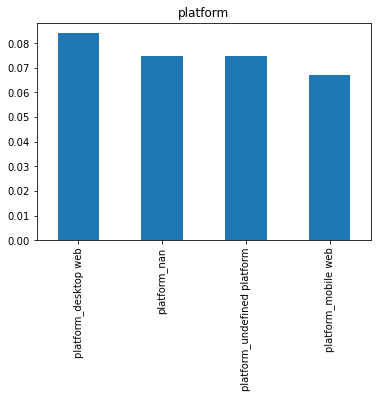

In [19]:
#country
pdp_iso = pdp.pdp_isolate(model=clf, 
                          dataset=train.drop(Y_VAR, axis=1),      
                          model_features=list(train.drop(Y_VAR, axis=1)), 
                          feature=[x for x in train.columns if "platform" in x], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='platform')

In [20]:
# Conclusions:
# Ad works well for hip hop genre lovers, less so for other genres
# There IS a few segments that have good performance but low absolute count (techno). Marketing should go after more of these people
# High conversion but low abs count -> put this on a scatter plot. Go after these
# Users with already saved payments do much better. Go after existing user base more
# Fix the ads for low conversion segments. Especially if they have high count